# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Anne-Aimée Bernard, Jonas Ulbrich, Arthur Bricq

**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

# Introduction

In this laboratory, we will perform different image processing techniques to extract 'object features' from different images. For this, we will use the MNIST dataset (http://yann.lecun.com/exdb/mnist/) that contains images of hand written numbers. The hypothetical goal is to obtain a strictly separable description of the objects using our features.

In the first part of this lab, we construct several **classifying features** only using the numbers '0' and '1' from the dataset with different techniques (fourier descriptors, several region based methods, skeleton-based methods) including both *contour based* and *region based* methods. Then, the second part of the lab simply consists of trying those features with more complex data (including both '2's and '3's), to see if we can easily perform multi-class classification using only 2 descripting features.

**Plan**
1. Part I: Constructing the features
    1. Fourier Descriptor
    2. Region Based methods
    3. Skeleton methods
2. Part II: Testing the features from part I

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import lab02_functions as imPro
import os
from lab02_functions import PlotData
import skimage
from numpy.fft import fft

## Presentation of the data

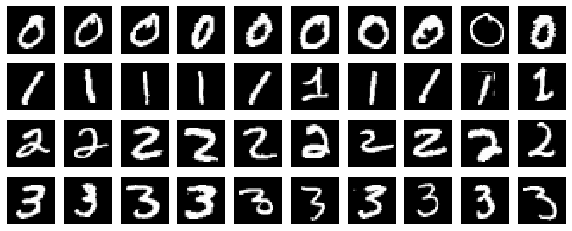

In [2]:
zeros = imPro.load_img_seq(file_path='lab-02-data/part1/0')
ones = imPro.load_img_seq(file_path='lab-02-data/part1/1')
twos = imPro.load_img_seq(file_path='lab-02-data/part2/2')
threes = imPro.load_img_seq(file_path='lab-02-data/part2/3')
imPro.plot_img_stacks([zeros, ones, twos, threes], nz = 10, fig_size=(10,4))

### Extracting contours

To find the contours, we used a very simple method named `get_outmost_contour` which is found in the lab02_functions.py. It perfoms an area closing followed by an canny edge detector. We use the area closing to get ride of the 'insides' contour within images. The following block of code shows four of the obtained contours (one for each shape) using our algorithm.


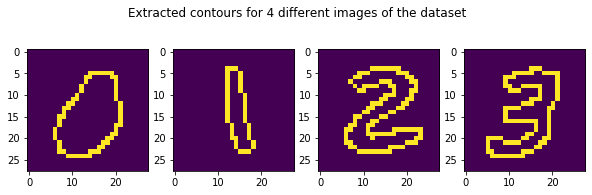

In [3]:
imgs = [zeros[0], ones[1], twos[2], threes[0]]
fig, axs = plt.subplots(1,4,figsize=(10,3))
for img, ax in zip(imgs, axs):
    contour = imPro.get_outmost_contour(img)
    img_c = imPro.get_contour_image(contour)
    ax.imshow(img_c)
fig.suptitle('Extracted contours for 4 different images of the dataset');

## 1.1 Fourier descriptors

### The theory

Fourier Descriptors (FD) is a method that can be used to encode contours and that offers a comparison tool between different contours. Basically it consists of computing the **discrete fourier transform** of the complex  path $u_k = x_k + j \cdot y_k$, where  $x_i, y_i$ ($i = 1,...,N$) are the N points of the contour we want to compute.


*How are the FDs encoding a contour ?* FD are Fourier Series. We can see them as a spectral decomposition of the complex path $u_k$. By only keeping the most important harmonics, it is possible to reconstruct a contour with almost all the variance of the initial contour.

Let's quickly now go through the most important features of Fourier Descriptors, that are the following
1. Path reconstruction using fourier descriptors
2. Unormalised description 
3. Normalisation of Fourier Descritors
4. Normalised descriptions

### Example of FD reconstruction 

<Figure size 432x288 with 0 Axes>

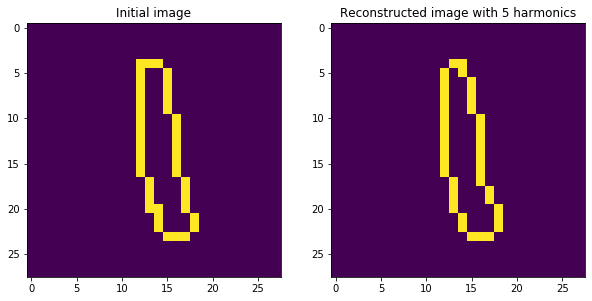

In [4]:
img = ones[1]
[X,Y] = imPro.get_outmost_contour(img)
im_contour = imPro.get_contour_image([X,Y])
signal = X + 1j * Y
fourier = np.fft.fft(signal)

k = 5 # number of harmonic to use
fourier[k:-k] = 0
fourier_inv = np.fft.ifft(fourier)
X_hat = np.rint(fourier_inv.real).astype(int)
Y_hat = np.rint(fourier_inv.imag).astype(int)
im_contour_hat = imPro.get_contour_image([X_hat, Y_hat])

plt.figure()
fig, axs = plt.subplots(1,2,figsize = (10,5))
axs[0].imshow(im_contour)
axs[0].set_title('Initial image')
axs[1].imshow(im_contour_hat)
axs[1].set_title('Reconstructed image with {} harmonics'.format(k));

We can see that the reconstruction is **almost perfect**, only using very few harmonics. This illustration shows us how to use the Fourier Descriptor for reconstruction, but eventually this is not what we want to do. We want to be able to classify using the Fourier Descriptors of one path. 

### Classification with Fourier Descriptors (no normalisation)

We are interested in **classifying shapes** using Fourier Descriptors. How can this be performed ? Fourier Descriptor are a way to encapsulate the most meaningful data about each curve, so to perform classification one needs to select some **features** that best describe this 'variance' among the data. Once we have meaningful features, we can simply plot them for different images and see wether yes or not classification could be performed. 

The first thing that one can try is to take the values of the **N-highest amplitudes** of the FDs for each contour and then plot it. In this case the *feature vector* is $x_{feature} = x = [A_1, A_2]$ or $x = [A_1, A_3]$

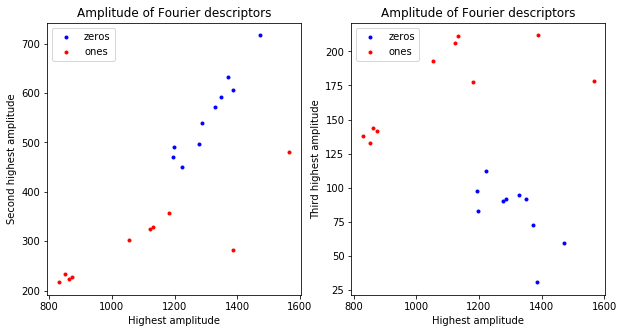

In [5]:
amplitudes_zeros, amplitudes_ones = [],[]
for img in zeros:
    [X,Y] = imPro.get_outmost_contour(img)    
    signal = X + 1j * Y
    fourier = np.fft.fft(signal)
    amplitudes = imPro.get_amplitude_first_descriptors(fourier, n_descriptor = 4)
    amplitudes_zeros.append(amplitudes)
for img in ones:
    [X,Y] = imPro.get_outmost_contour(img)
    signal = X + 1j * Y
    fourier = np.fft.fft(signal)
    amplitudes = imPro.get_amplitude_first_descriptors(fourier, n_descriptor = 4)
    amplitudes_ones.append(amplitudes)
amplitudes_zeros, amplitudes_ones = np.array(amplitudes_zeros), np.array(amplitudes_ones)

fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].plot(amplitudes_zeros[:,0], amplitudes_zeros[:,1],'.b', label = 'zeros')
axs[0].plot(amplitudes_ones[:,0], amplitudes_ones[:,1],'.r', label = 'ones')
axs[0].set_xlabel('Highest amplitude')
axs[0].set_ylabel('Second highest amplitude')
axs[0].set_title('Amplitude of Fourier descriptors')
axs[0].legend();
axs[1].plot(amplitudes_zeros[:,0], amplitudes_zeros[:,2],'.b', label = 'zeros')
axs[1].plot(amplitudes_ones[:,0], amplitudes_ones[:,2],'.r', label = 'ones')
axs[1].set_xlabel('Highest amplitude')
axs[1].set_ylabel('Third highest amplitude')
axs[1].set_title('Amplitude of Fourier descriptors')
axs[1].legend();

We see using that already with this method  the contours are quite separable. Both **feature vectors** offer projections that are really good for classifying the '0's and the '1's.

### Fourier Descriptors Normalisation

There are four transformations that can influence Fourier Transforms: *rotation, scaling, translation and the selection of the starting point*. What we want to do is to make a robust method that doesn't depend on any of those transformations. Each different case needs to be traited separatly. Let's look at what happens to the FD $f_l$ after those transformations.

**Effect of each transformation**

1. **Scalling**: After scalling, $f_l$ becomes $f_l'=s\cdot f_l$. 

2. **Translation**: After a translation by an offset $z_0$, $f_l$ becomes $f_l'=f_l + z_0 \cdot \delta(l)$, i.e. it affects only the DC component of the FDs. 

3. **Selection of starting points**: After selecting $k_0$ as initial point, $f_l$ becomes $f_l'=f_l \cdot e^{-j\cdot\frac{2\pi k_0}{N}l}$. 

4. **Rotation**: After a rotation of $\theta$, $f_l$ becomes $f_l'=f_l \cdot e^{j\theta}$ which is an offset of all the phases by a constant value. 

The following block illustrates the effect of rotation and of scalling (just as a 'proof' of concept) and we see that indeed the theory is respected when applying transformations. 

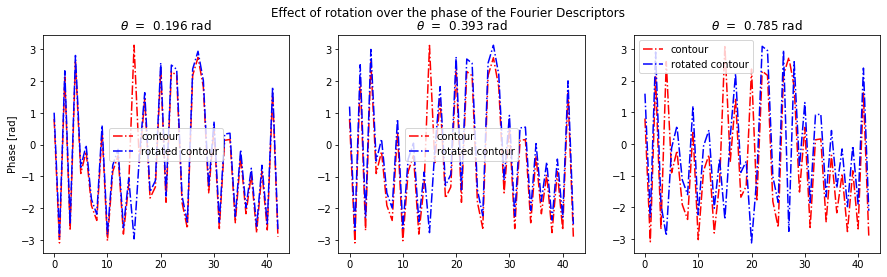

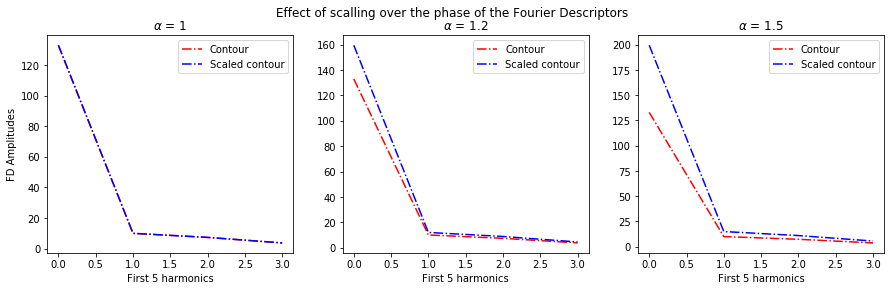

In [6]:
# %% Rotation effect (the modulus is constant)
fig, axs = plt.subplots(1,3,figsize = (15,4))
img = ones[1]
imPro.plot_FD_rotation_invariance(img, np.pi/16, axs[0])
imPro.plot_FD_rotation_invariance(img, np.pi/8, axs[1])
imPro.plot_FD_rotation_invariance(img, np.pi/4, axs[2])
axs[0].set_ylabel('Phase [rad]')
fig.suptitle("Effect of rotation over the phase of the Fourier Descriptors");

# %% Scalling effect (the phase is constant)
fig, axs = plt.subplots(1,3,figsize = (15,4))
img = ones[1]
imPro.plot_FD_scaling_invariance(img, 1, axs[0])
imPro.plot_FD_scaling_invariance(img, 1.2, axs[1])
imPro.plot_FD_scaling_invariance(img, 1.5, axs[2])
axs[0].set_ylabel('FD Amplitudes')
fig.suptitle("Effect of scalling over the phase of the Fourier Descriptors");

Here is what we can do to make our FD robust to all transformation

**Normalisation of each transformation**

1. **Scalling**: take the norm of the first FD $r_1 = |f_1|$ and devide every FDs by $r_1$.
2. **Translation**: set the initial FD $f_0$ at zero.
3. **Starting-point**: multiply every FD by a phase shift of $e^{-j\phi_1 k}$ where $\phi_1$ is the phase of the first FD.
4. **Rotation**: set the phase of the FD with highest amplitude at zero, and then shift all the other phase accordingly

One can **assess** the normalisation with the following block of code, where the first part define the transformation to be applied.

**Note**: *the rotation invariance was quite hard to handle. The easiest way was to simply get rid of the phase of each FD (which makes them invariant...) but this is NOT satisfying. We found another method (described above) but it comes at a price: * **Fourier descriptors can't be rotation invariant and starting-point invariant at the same time.** *As we think rotation are not as important as the selection of the stating point, we prefered to keep starting point invariance for the next parts*


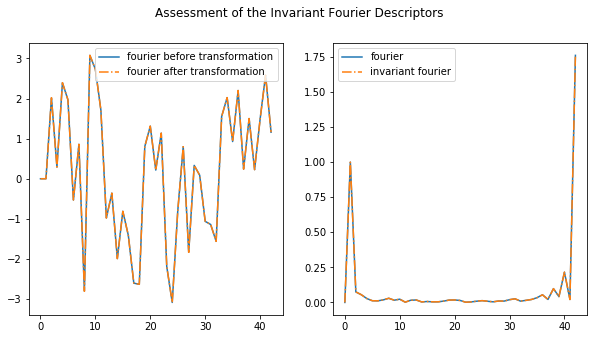

In [7]:
# ASSESSMENT OF INVARIANCE #

### Transformation parameters
# 1. rotation (if not to zero, then remove starting point shift)
theta = np.pi/4 * 0
R_rot = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
# 2. scalling
a = 1.3
R_sca = np.array([[a,0],[0,a]])
# 3. translation 
tx = 2
ty = 0
# 4. Starting point 
k_0 = 3

### Construct the fourier descriptors
img = ones[1]
X1, Y1 = imPro.get_outmost_contour(img)
contour1 = np.column_stack([X1, Y1])
R = R_sca @ R_rot
contour2 = contour1 @ R
contour2 = contour2 + tx + 1j*ty
X2, Y2 = contour2[:, 0], contour2[:, 1]
if k_0 > 0:
    X2 = np.concatenate((X2[k_0:],X2[0:k_0]))
    Y2 = np.concatenate((Y2[k_0:],Y2[0:k_0]))
    
signal1 = X1 + 1j * Y1
fourier1 = np.fft.fft(signal1)
signal2 = X2 + 1j * Y2
fourier2 = np.fft.fft(signal2)

### Make fourier Invariant
fourier1_n = imPro.translation_invariance(fourier1)
fourier2_n = imPro.translation_invariance(fourier2)
fourier1_n = imPro.scaling_invariance(fourier1)
fourier2_n = imPro.scaling_invariance(fourier2)
fourier1_n = imPro.starting_point_invariance(fourier1_n)
fourier2_n = imPro.starting_point_invariance(fourier2_n)

# Plotting all this 
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(np.angle(fourier1_n), label = 'fourier before transformation')
axs[0].plot(np.angle(fourier2_n),'-.', label = 'fourier after transformation')
axs[1].plot(np.abs(fourier1_n), label = 'fourier')
axs[1].plot(np.abs(fourier2_n),'-.', label = 'invariant fourier')
axs[0].legend();
axs[1].legend();
fig.suptitle('Assessment of the Invariant Fourier Descriptors');

We clearly see that the normalisation works perfectly ! 

### Feature vector with normalised Fourier Descriptors

Now that we have robust fourier descriptors that have been assessed, in order to have a good classification we must use a good feature vector $x_{features}$ that embededs appropriate properties. 

The selection of the feature vector was long and involved quite a lot of 'trial and error' research. The feature vector that we used for classification is 
$$x = \big(\mathrm{Re}f_1, |f_1|, |f_{1n}|, |f_1-f_{1n}|, \mathrm{Re}f_2, \mathrm{Re}f_0, \mathrm{Im}f_0 \big)$$

The results are displayed in the following block of code. 

*Note for the reader: in order to have lighter code, we made use of a class 'PlotData' which help us building very specific plots by selecting what invariances to apply and what features to use for the specific plot.*

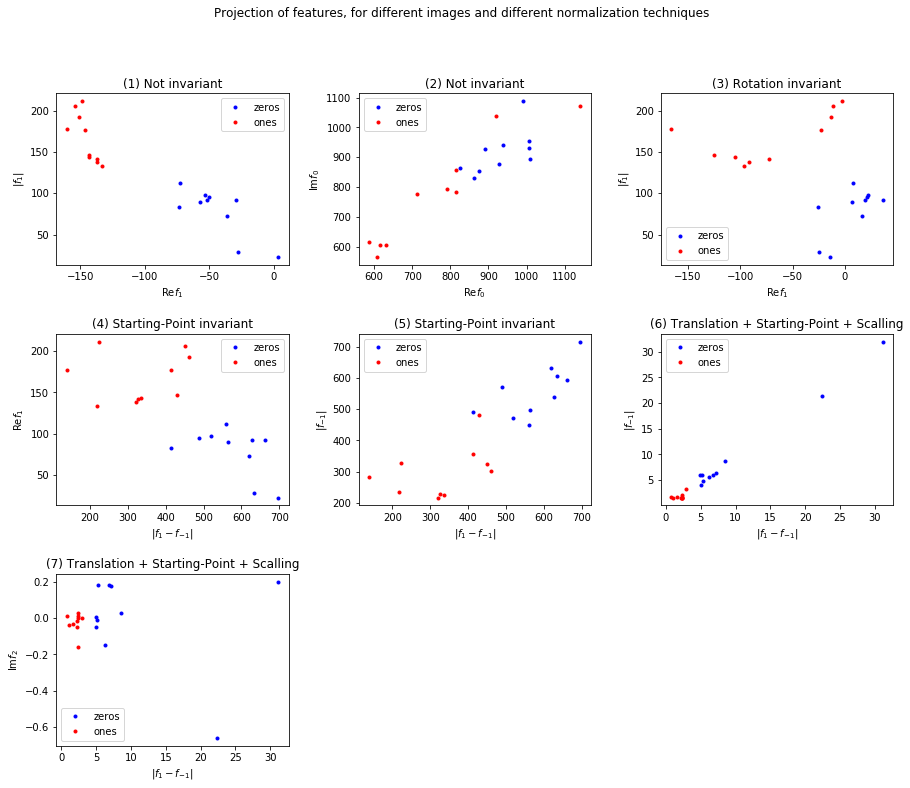

In [8]:
# 1. Construction of the experiment (make the data-model to generate plot easily)
plots_to_make = [] 
plots_to_make.append(PlotData("Not invariant", [0,0,0,0], [0,1]))
plots_to_make.append(PlotData("Not invariant", [0,0,0,0], [5,6]))
plots_to_make.append(PlotData("Rotation invariant", [1,0,0,0], [0, 1]))
plots_to_make.append(PlotData("Starting-Point invariant", [0,0,0,1], [3, 0]))
plots_to_make.append(PlotData("Starting-Point invariant", [0,0,0,1], [3, 2]))
plots_to_make.append(PlotData("Translation + Starting-Point + Scalling", [0,1,1,1], [3, 2]))
plots_to_make.append(PlotData("Translation + Starting-Point + Scalling", [0,1,1,1], [3, 4]))

# 2. Make some nice plots illustrating all this
fig, axs = plt.subplots(3,3,figsize = (15,12))
axs = axs.ravel()
for i, plotData in enumerate(plots_to_make):
    x_zeros, x_ones = [], []
    ax = axs[i]
    for img in zeros: x_zeros.append(imPro.get_feature_vector(img, plotData.invariances))
    for img in ones: x_ones.append(imPro.get_feature_vector(img, plotData.invariances))
    x_zeros, x_ones = np.array(x_zeros), np.array(x_ones)
    ax.plot(x_zeros[:,plotData.features[0]], x_zeros[:,plotData.features[1]],'.b', label = 'zeros')
    ax.plot(x_ones[:,plotData.features[0]], x_ones[:,plotData.features[1]],'.r', label = 'ones')
    labels = plotData.get_features_label()
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_title("({}) ".format(i+1) + plotData.name)
    ax.legend()
fig.subplots_adjust(hspace=0.4, wspace = 0.3)
fig.delaxes(axs[-1]), fig.delaxes(axs[-2])
fig.suptitle("Projection of features, for different images and different normalization techniques");

The following plots are quite interesting. Every plot contains 2 features (selected among our feature vector), and has some invariances applied to it. We see that the best classification is the one without any invariances applied to it. This can be explained by two facts, which are
- each invariance somehow reduce the amount of information carried by the features vector
- the method to find the contour is always the same, meaning that the starting point is always on top of the shape and the shapes are already very coherent between each others.
If the dataset wouldn't as coherent as this one, normalisation would probably be more effective. However, we see that the points are still well classified with some invariances applied to it. 

## 1.2 Region based Methods

We are interested in region based methods. We have tested several region based descriptors : 
- area and area in the polygon connecting the contour points, 
- perimeter (translation and rotation invariant, still scale variant). 
- compacity descriptor (also scale invariant). 
- axis of inertia (translation invariant) 

The following block of code shows how to do this.

In [9]:

def region_based_features(images):
    """
    Returns an array of region based features for all the images in the input
    
    :param images:  group of grayscale images of numbers
    :return: param_images np.array of all the region based features of the input images
    """
    param_images = []
    for img in images:
        binary=imPro.binarize(img)
        param=[]
        param.append(imPro.area(binary))
        param.append(imPro.perimeter(img))
        param.append(imPro.compacity(img))
        inertias = imPro.inertia(img)
        param.append(inertias[0])
        param.append(inertias[1])
        param_images.append(param)
    param_images = np.array(param_images)
    return param_images

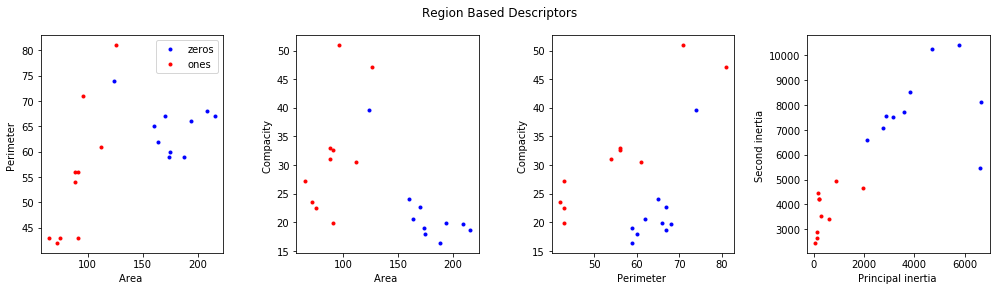

In [10]:
param_zeros = region_based_features(zeros)
param_ones = region_based_features(ones)


fig, axs = plt.subplots(1,4, figsize = (17,4))
axs[0].plot(param_zeros[:,0], param_zeros[:,1],'.b', label = 'zeros')
axs[0].plot(param_ones[:,0], param_ones[:,1],'.r', label = 'ones')
axs[0].set_xlabel('Area ')
axs[0].set_ylabel('Perimeter ')
axs[0].legend()

axs[1].plot(param_zeros[:,0], param_zeros[:,2],'.b', label = 'zeros')
axs[1].plot(param_ones[:,0], param_ones[:,2],'.r', label = 'ones')
axs[1].set_xlabel('Area ')
axs[1].set_ylabel('Compacity ')

axs[2].plot(param_zeros[:,1], param_zeros[:,2],'.b', label = 'zeros')
axs[2].plot(param_ones[:,1], param_ones[:,2],'.r', label = 'ones')
axs[2].set_xlabel('Perimeter ')
axs[2].set_ylabel('Compacity ')

axs[3].plot(param_zeros[:,3], param_zeros[:,4],'.b', label = 'zeros')
axs[3].plot(param_ones[:,3], param_ones[:,4],'.r', label = 'ones')
axs[3].set_xlabel('Principal inertia ')
axs[3].set_ylabel('Second inertia ')


fig.suptitle('Region Based Descriptors');
fig.subplots_adjust(wspace=0.4)

We can use region based descriptors to classify the 0s and 1s. It seems that the perimeter and the area are sufficient for this purpose. 

## 1.3 Skeleton based method
The method presented here is similar to a contour based but relies instead on the **morphological skeleton** of the image. This so called skeleton is built using morphological operations like erosions and dilations. Once a skeleton has been extracted, same or similar approaches as for contour and/or region based feature detection can be applied. In this section two examples are tested, showing a good choice and a bad choice for skeleton features and how other features could be described.

The first steps are therefore the skeletonization of the images. The results are shown below for the two series of handwritten glyphs:

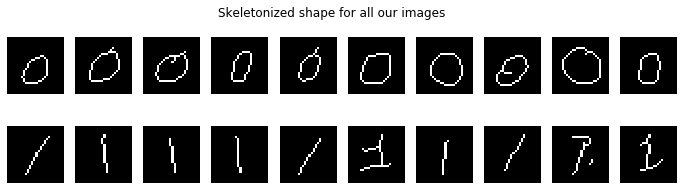

In [11]:
#load image stacks
path_to_img_data='lab-02-data/part1/'
img_zeros=imPro.load_img_seq(os.path.join(path_to_img_data, '0'))
img_ones=imPro.load_img_seq(os.path.join(path_to_img_data, '1'))

#skeletonize stacks
skel_zeros=imPro.skel_img_stack(img_zeros)
skel_ones=imPro.skel_img_stack(img_ones)

#plot skeletons of glyphs
fig, axes = plt.subplots(2, len(skel_ones), figsize=(12, 3))
for ax, im in zip(axes[0], skel_zeros):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
for ax, im in zip(axes[1], skel_ones):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
fig.suptitle('Skeletonized shape for all our images');

### Feature Extraction from Skeletons
When working with classification algorithms an important part for the proper classification is the choice of good features. This is always true and here is an example of a bad choice: a pair of features could be the **two inertias along the principal axes of the object**. However, knowing that some _ones_ are more than just a line and have a given width which is comparable with that of the _zeros_, one may expect this features to fail when comparing the two classes. The same is true for the very slim zeros which may be confused with ones due to their small "lateral inertia".

**The inertias are deduced from the covariance matrix** of the objects, which is build from the pixels coordinates, the pixel values and its center of mass. Once this matrix is computed the eigenvalues are extracted, which is equivalent to analysing the inertia along the principal axis of the object. This is done as follows:

In [12]:
u10, u20, u11, u21=[], [], [], []
for i in range(len(skel_zeros)):
    # find eigenvalues (inertia) of zeros along principal axis
    Lambda,_=np.linalg.eig(imPro.object_covar_mat(skel_zeros[i]))
    u10.append(Lambda[0])
    u20.append(Lambda[1])

    #do the same for ones
    Lambda,_=np.linalg.eig(imPro.object_covar_mat(skel_ones[i]))
    u11.append(Lambda[0])
    u21.append(Lambda[1])

The second pair of features that we are going to analyze are the **relative distances between the handwritten glyph and a reference one**. This is a good feature for **binary classification** of the type "it is part of this class" or "it is not part of this class", if low dimentionality of the feature space is important. This can be understood with an example of classification where we want to classify several characters like 1,2,3 and 4. In this case to properly separate them and classify them, one would would need more than just two distances, which forces the classification algorithms in higher dimentions if no reduction of dimentionality is applied. Otherwise, one could only say with two features something like: "the glyph is a 1" or "the glyph is not a 1". This again could be overcome by doing a chained classification so that if "it is not a 1" the the same approach is made testing for another glyph, until a test is positive.

Since the distinction we here seek to accomplish is only between two glyphs, this approach is valid and can easily be implemented in a 2D featurespace. Therefore, the first step is to generate reference glyphs, skeletonize them and build a distance map:

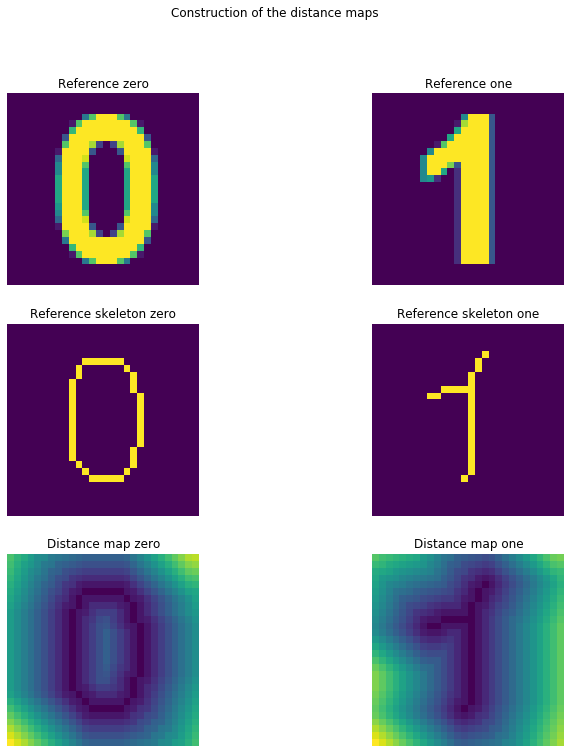

In [13]:
#read and plot reference images
ref_path='lab-02-data/ref/'
ref_zero=skimage.io.imread(os.path.join(ref_path,'reference0.png'))
ref_one=skimage.io.imread(os.path.join(ref_path,'reference1.png'))

#plot reference images
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0][0].imshow(ref_zero)
ax[0][1].imshow(ref_one)
ax[0][0].set_title('Reference zero')
ax[0][0].axis('off')
ax[0][1].set_title('Reference one')
ax[0][1].axis('off')

#skeletonize and plot ref images
ref_zero=imPro.skel_and_thld(ref_zero)
ref_one=imPro.skel_and_thld(ref_one)

#create and plot distance map
zero_dist_map=imPro.dist_map(ref_zero.astype(int))
one_dist_map=imPro.dist_map(ref_one.astype(int))

#plot reference skeletons
ax[1][0].imshow(ref_zero)
ax[1][1].imshow(ref_one)
ax[1][0].set_title('Reference skeleton zero')
ax[1][0].axis('off')
ax[1][1].set_title('Reference skeleton one')
ax[1][1].axis('off')

ax[2][0].imshow(zero_dist_map)
ax[2][1].imshow(one_dist_map)
ax[2][0].set_title('Distance map zero')
ax[2][0].axis('off')
ax[2][1].set_title('Distance map one')
ax[2][1].axis('off');
fig.suptitle('Construction of the distance maps');

### Comparison
Now that the maps have been created it is time to compare the mean distances, considered as features here. Note that dx0 is average ditance of object _x_ to the _zeros_ and dx1 is defined accordingly for the _ones_ in the next section of code

In [14]:
d00, d01, d10, d11=[], [], [], []

for img in skel_ones:
    #center objects:
    x_com,y_com=imPro.com(img)
    img=np.roll(img,(int(x_com),int(y_com)))
    #compute total number of pixels of object
    N=np.sum(img)
    #compute average distance
    d10.append(np.sum(zero_dist_map[img])/N)
    d11.append(np.sum(one_dist_map[img])/N)

for img in skel_zeros:
    #center objects:
    x_com,y_com=imPro.com(img)
    img=np.roll(img,(int(x_com),int(y_com)))
    #compute total number of pixels of object
    N=np.sum(img)
    #compute average distance
    d00.append(np.sum(zero_dist_map[img])/N)
    d01.append(np.sum(one_dist_map[img])/N)

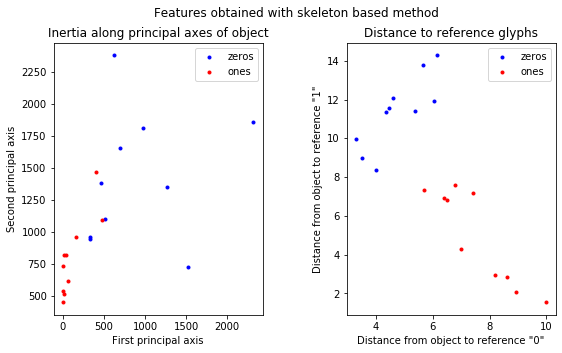

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
ax[0].plot(u10,u20,'.b',label='zeros')
ax[0].plot(u11,u21,'.r',label='ones')
ax[0].set_title("Inertia along principal axes of object")
ax[0].set_xlabel("First principal axis")
ax[0].set_ylabel("Second principal axis")
ax[0].legend()

ax[1].plot(d00,d01,'.b',label='zeros')
ax[1].plot(d10,d11,'.r',label='ones')
ax[1].set_xlabel('Distance from object to reference "0"')
ax[1].set_ylabel('Distance from object to reference "1"')
ax[1].set_title("Distance to reference glyphs")
ax[1].legend();
fig.suptitle('Features obtained with skeleton based method');
fig.subplots_adjust(wspace = 0.4)

**First Pair of Features**

As expected, the classes are not completly separable and overlap as we can see in the plot below. This means that those are not good features to separate those two objects one from the other. Indeed, the two _ones_ which are a bit larger are confused with _zeros_ wich are a bit slimmer. Nonetheless, we can see from this that this approach would probably work just fine if the _ones_ where all simple lines. Indeed, the _ones_ which are a line present the second inertia to be negligible compared to that of a _zero_. Pruning the skeleton could probably further improve the separation between the two classes. It can be interesting to note that the computation of the inertia is invariant to rotation as it extract the object's principal axes.

**Second Pair of Features**

The result of this feature analysis shows that those features could be used to linearly separate the two glyphs one fro the other. Indeed, as one would expect, the _zeros_ show greater distance to the reference _one_ and a smaller deistance to the reference _zero_, and the same reasoning applies for the _ones_ which show greater proximity to the reference _one_ rather than the reference _zero_. The result is shown below. From this we can conclude that it is important to carefully choose the features if a good separation needs to be achived. Indeed in the example above the inertia of the object alone does not suffice to classify the different objects without mistakes, wherease this approach of realtive distances is more promising in this case.


# Part 2

In this second part of the lab, we want to answer to the following question.

> *Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?*

We are going to apply the same algorithm as before, and observe the results. 

## 2.1. Fourier Descriptors

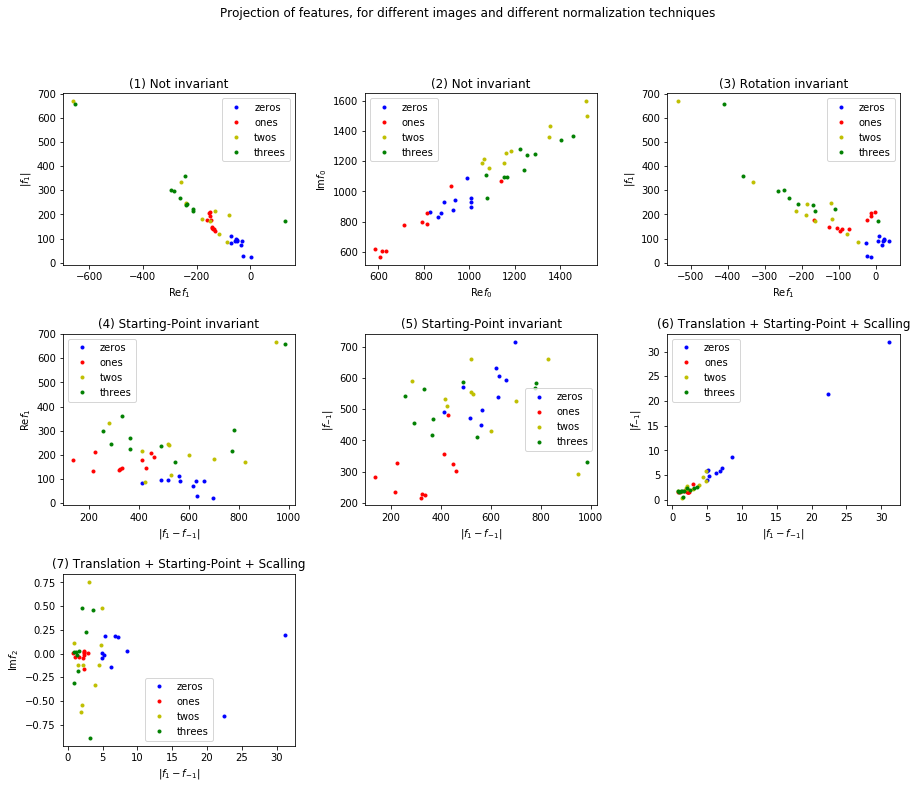

In [16]:
# 1. Construction of the experiment (make the data-model to generate plot easily)
plots_to_make = [] 
plots_to_make.append(PlotData("Not invariant", [0,0,0,0], [0,1]))
plots_to_make.append(PlotData("Not invariant", [0,0,0,0], [5,6]))
plots_to_make.append(PlotData("Rotation invariant", [1,0,0,0], [0, 1]))
plots_to_make.append(PlotData("Starting-Point invariant", [0,0,0,1], [3, 0]))
plots_to_make.append(PlotData("Starting-Point invariant", [0,0,0,1], [3, 2]))
plots_to_make.append(PlotData("Translation + Starting-Point + Scalling", [0,1,1,1], [3, 2]))
plots_to_make.append(PlotData("Translation + Starting-Point + Scalling", [0,1,1,1], [3, 4]))

# 2. Make some nice plots illustrating all this
fig, axs = plt.subplots(3,3,figsize = (15,12))
axs = axs.ravel()
for i, plotData in enumerate(plots_to_make):
    x_zeros, x_ones, x_twos, x_threes = [], [], [], []
    ax = axs[i]
    for img in zeros: x_zeros.append(imPro.get_feature_vector(img, plotData.invariances))
    for img in ones: x_ones.append(imPro.get_feature_vector(img, plotData.invariances))
    for img in twos: x_twos.append(imPro.get_feature_vector(img, plotData.invariances))
    for img in threes: x_threes.append(imPro.get_feature_vector(img, plotData.invariances))
    x_zeros, x_ones, x_twos, x_threes = np.array(x_zeros), np.array(x_ones), np.array(x_twos), np.array(x_threes)
    ax.plot(x_zeros[:,plotData.features[0]], x_zeros[:,plotData.features[1]],'.b', label = 'zeros')
    ax.plot(x_ones[:,plotData.features[0]], x_ones[:,plotData.features[1]],'.r', label = 'ones')
    ax.plot(x_twos[:,plotData.features[0]], x_twos[:,plotData.features[1]],'.y', label = 'twos')
    ax.plot(x_threes[:,plotData.features[0]], x_threes[:,plotData.features[1]],'.g', label = 'threes')
    labels = plotData.get_features_label()
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_title("({}) ".format(i+1) + plotData.name)
    ax.legend()
fig.subplots_adjust(hspace=0.4, wspace = 0.3)
fig.delaxes(axs[-1]), fig.delaxes(axs[-2])
fig.suptitle("Projection of features, for different images and different normalization techniques");


## 2.2. Region-based methods

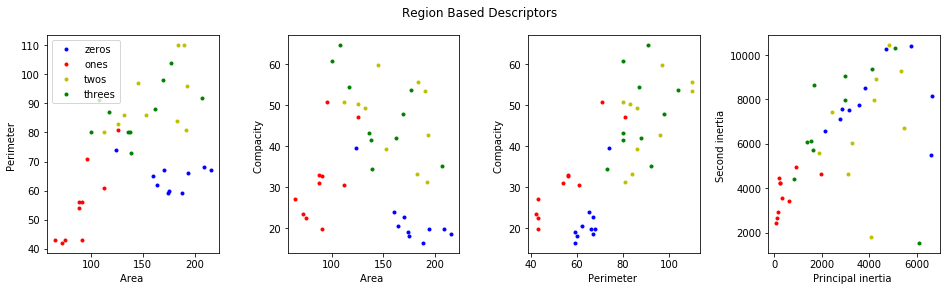

In [17]:
param_zeros = region_based_features(zeros)
param_ones = region_based_features(ones)
param_twos = region_based_features(twos)
param_threes = region_based_features(threes)

fig, axs = plt.subplots(1,4, figsize = (16,4))
axs[0].plot(param_zeros[:,0], param_zeros[:,1],'.b', label = 'zeros')
axs[0].plot(param_ones[:,0], param_ones[:,1],'.r', label = 'ones')
axs[0].plot(param_twos[:,0], param_twos[:,1],'.y', label = 'twos')
axs[0].plot(param_threes[:,0], param_threes[:,1],'.g', label = 'threes')
axs[0].set_xlabel('Area ')
axs[0].set_ylabel('Perimeter ')
axs[0].legend()

axs[1].plot(param_zeros[:,0], param_zeros[:,2],'.b', label = 'zeros')
axs[1].plot(param_ones[:,0], param_ones[:,2],'.r', label = 'ones')
axs[1].plot(param_twos[:,0], param_twos[:,2],'.y', label = 'twos')
axs[1].plot(param_threes[:,0], param_threes[:,2],'.g', label = 'threes')
axs[1].set_xlabel('Area ')
axs[1].set_ylabel('Compacity ')

axs[2].plot(param_zeros[:,1], param_zeros[:,2],'.b', label = 'zeros')
axs[2].plot(param_ones[:,1], param_ones[:,2],'.r', label = 'ones')
axs[2].plot(param_twos[:,1], param_twos[:,2],'.y', label = 'twos')
axs[2].plot(param_threes[:,1], param_threes[:,2],'.g', label = 'threes')
axs[2].set_xlabel('Perimeter ')
axs[2].set_ylabel('Compacity ')

axs[3].plot(param_zeros[:,3], param_zeros[:,4],'.b', label = 'zeros')
axs[3].plot(param_ones[:,3], param_ones[:,4],'.r', label = 'ones')
axs[3].plot(param_twos[:,3], param_twos[:,4],'.y', label = 'twos')
axs[3].plot(param_threes[:,3], param_threes[:,4],'.g', label = 'threes')
axs[3].set_xlabel('Principal inertia ')
axs[3].set_ylabel('Second inertia ')

fig.subplots_adjust(wspace=0.4)
fig.suptitle('Region Based Descriptors');

(as explained above it is not possible to represent over 1 plot the result of our **skeleton based method** as the features are intrinsic to a **binary classification**. It is possible to create a mutli-class classification algorithm, but it wouldn't make any sense to plot it over a 2d plot (as we would be talking about 4 dimensional data). Therefore, we decided to not implement it here. 

# Discussion and conclusion



We realized using those results that it is not so easy to discriminate the four classes (0, 1, 2 and 3s) using only two parameters at the same time. In some cases, as in plots (1), (2) or (4) using Fourier Descriptors or with plot (1) of region based methods, it is possible to perform a three-classes classification though (to classify at the same time the 0s, the 1s and the 3s). But we observe that the _twos_ and the _threes_ are very always classified in the same regions of the screen, which makes it impossible to discriminate one from the other. This might be explained by the similarities between the shape of a 2 and a 3 (see the top of lab report). 

However, it would be possible to perform such kinds of classification using higher dimensional spaces (as using our skeleton based method !), or by applying some machine learning classification algorithm over the higher dimensional feature vector extracted by Fourier Descriptors methods. 

Another possibility to make a better multi-classes classification would be to use a classifying neural network.